In [1]:
import pandas as pd
import numpy as np

column_names = ['center_image', 'left_image', 'right_image', 'steering_angle', 'throttle', 'brake', 'speed']

In [2]:
from os.path import basename

def normalize_filepaths(dataframe, parent_filepath):
    for column in ['center_image', 'left_image', 'right_image']:
        dataframe[column] = dataframe[column].apply(lambda filepath: parent_filepath + basename(filepath))
    return dataframe

steering_correction = 0.07

def steering_corrected_dataframe(dataframe, column, steering_correction):
    dataframe_copy = dataframe[[column, 'steering_angle']].copy()
    dataframe_copy['steering_angle'] = dataframe_copy['steering_angle'].apply(lambda angle: float(angle) + steering_correction)
    dataframe_copy.columns = ['center_image', 'steering_angle']
    return dataframe_copy

parent_directories = [
    'data/track1/forward/center', # TODO explain in the README that 'forward' & 'backward' mean counter-clockwise and clockwise around the track
    'data/track1/backward/center'
    #'data/track1/forward/leg1recovery',
    #'data/track1/forward/leg1turn1recovery',
    #'data/track1/forward/leg1hires',
    #'data/track1/forward/turn1',
    #'data/track1/forward/turn1apex',
    #'data/track1/forward/turn1end',
    #'data/track1/forward/leg1turn1bridge',
    #'data/track1/forward/turn1recovery',
    #'data/track1/forward/postbridgeturn'
]
training_dataframe = None
for parent_directory in parent_directories:
    dataframe = pd.read_csv(parent_directory + '/driving_log.csv', header=None, names=column_names, low_memory=False)
    left_image_steering_corrected = steering_corrected_dataframe(dataframe, 'left_image', steering_correction)
    right_image_steering_corrected = steering_corrected_dataframe(dataframe, 'right_image', -steering_correction)
    if type(training_dataframe) is pd.DataFrame:
        training_dataframe = pd.concat([training_dataframe, dataframe, left_image_steering_corrected, right_image_steering_corrected])
    else:
        training_dataframe = pd.concat([dataframe, left_image_steering_corrected, right_image_steering_corrected])

# Data Balance

In [3]:
for directory in parent_directories:
    !echo {directory} `ls -al {directory}/IMG | wc -l`

data/track1/forward/center 107058
data/track1/backward/center 128763


In [4]:
# shuffle training set for training / validation split
shuffled_training_dataframe = training_dataframe.sample(frac=1)
#shuffled_training_dataframe.head()

In [5]:
from sklearn.model_selection import train_test_split

training_samples, validation_samples = train_test_split(shuffled_training_dataframe)
#print(len(training_dataframe), len(training_samples), len(validation_samples))
training_samples = training_samples.reset_index(drop=True)
validation_samples = validation_samples.reset_index(drop=True)
#training_samples.head()

In [6]:
from keras.applications.vgg16 import VGG16
from keras.layers import BatchNormalization, Convolution2D, Dense, Dropout, ELU, Flatten, Input, Lambda
from keras.models import Model, Sequential
from keras.optimizers import Adam, Nadam
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

pixel_height = int(config['input_size']['height'])
pixel_width = int(config['input_size']['width'])
color_channels = 3
target_size = (pixel_height, pixel_width)
input_shape = (pixel_height, pixel_width, color_channels)

model = Sequential() # comma.ai
model.add(BatchNormalization(input_shape=input_shape))
#model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1))
optimizer = Nadam()
model.compile(optimizer=optimizer, loss='mse')

Using TensorFlow backend.


In [7]:
from dataframe_iterator import DataframeIterator

batch_size = 256
brightness_factor_min = 0.25
training_generator = DataframeIterator(training_samples, 
                                       brightness_factor_min=brightness_factor_min,
                                       translation=True,
                                       horizontal_flip=True, 
                                       target_size=target_size, 
                                       batch_size=batch_size)
validation_generator = DataframeIterator(validation_samples, 
                                         target_size=target_size, 
                                         batch_size=batch_size, 
                                         shuffle=False)
#test_generator = DataframeIterator(test_samples, target_size=target_size, batch_size=batch_size, shuffle=False)
#training_generator.next()

# Test Image Transformations

steering angle 0.08997131


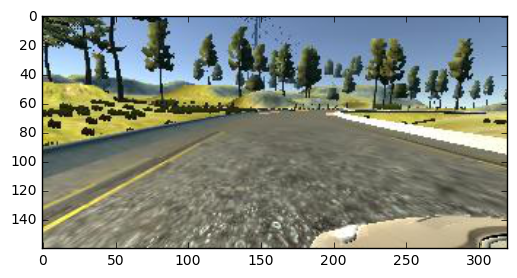

In [8]:
%matplotlib inline

from matplotlib.pyplot import imshow

test_sample =  training_samples.sample(1).iloc[0]
test_img_filepath = test_sample['center_image'].strip()
steering_angle = test_sample['steering_angle']
print('steering angle', steering_angle)
img = load_img(test_img_filepath)#, target_size=self.target_size)
imshow(img)

translated steering angle 0.0909703347424


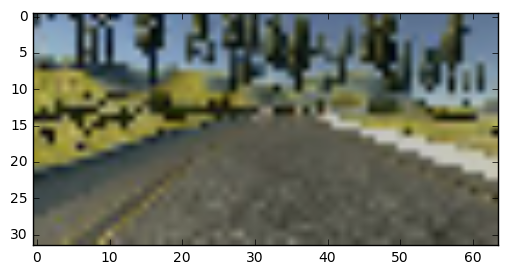

In [9]:
img, steering_angle = translate(img, steering_angle)
#imshow(img)
img = brighten_or_darken(img, brightness_factor_min)
img = cropout_sky_hood(img)
print('translated steering angle', steering_angle)
img = img.resize((pixel_width, pixel_height))
imshow(img)

# Training

In [10]:
max_epochs = 8

In [11]:
#training_generator = generate_from_dataframe(training_samples)
training_samples_count = len(training_samples)
#validation_generator = generate_from_dataframe(validation_samples)
validation_samples_count = len(validation_samples)
#next(training_generator)
#test_samples_count = len(test_samples)

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [13]:
# resume training
#model.load_weights('model.h5')

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=2, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='comma.model.weights.{epoch:02d}-{val_loss:.5f}.h5', verbose=1, save_best_only=True, save_weights_only=True)
learning_rate_plateau_reducer = ReduceLROnPlateau(verbose=1, patience=0, epsilon=1e-5)
model.fit_generator(training_generator, training_samples_count, # account for: horizontal flipping, x-translation range
                    max_epochs, 
                    callbacks=[model_checkpoint, learning_rate_plateau_reducer, early_stopping],
                    validation_data=validation_generator, 
                    nb_val_samples=validation_samples_count)

Epoch 1/8
176861/176861 [==============================] - 542s - loss: 0.1317 - val_loss: 0.0070
Epoch 2/8
176861/176861 [==============================] - 474s - loss: 0.0098 - val_loss: 0.0062
Epoch 3/8
176861/176861 [==============================] - 475s - loss: 0.0088 - val_loss: 0.0057
Epoch 4/8
176861/176861 [==============================] - 475s - loss: 0.0080 - val_loss: 0.0047
Epoch 5/8
176861/176861 [==============================] - 475s - loss: 0.0073 - val_loss: 0.0043
Epoch 6/8
176861/176861 [==============================] - 476s - loss: 0.0065 - val_loss: 0.0042
Epoch 7/8
176861/176861 [==============================] - 476s - loss: 0.0060 - val_loss: 0.0041
Epoch 8/8
176861/176861 [==============================] - 483s - loss: 0.0055 - val_loss: 0.0032


In [14]:
#model.save_weights('model.h5')

In [7]:
import json

model_json_string = model.to_json()
with open('model.json', 'w') as outfile:
    json.dump(model_json_string, outfile)

# Testing...

In [10]:
#model.load_weights('model.h5')

In [12]:
model.evaluate_generator(test_generator, test_samples_count) 
#0.0010745568868129561 
#0.0014838234640777231
#0.0028282808319534665
#0.0059747247878073019
#0.0031086671844570411
#0.0053260803041177314

0.015796573778202965

# Inspect Worst Predictions

In [12]:
test_predictions = model.predict_generator(test_generator, test_samples_count)

In [13]:
test_predictions

array([[-0.03155801],
       [-0.03315222],
       [-0.03006131],
       ..., 
       [-0.02560698],
       [-0.02625413],
       [-0.02782261]], dtype=float32)

In [13]:
len(test_predictions)

14985

In [14]:
len(test_samples)

14985

In [15]:
print(test_predictions.shape, test_samples['steering_angle'].as_matrix().shape)

(14985, 1) (14985,)


In [16]:
actual_steering_angles = test_samples['steering_angle'].as_matrix().reshape((len(test_samples), 1))

In [17]:
errors = test_predictions - actual_steering_angles

In [18]:
indices_sorted_by_error = np.argsort(errors, axis=0)
indices_sorted_by_error

array([[10442],
       [10440],
       [10441],
       ..., 
       [ 8313],
       [ 8361],
       [ 8360]])

In [19]:
leftmost_error_index, rightmost_error_index = indices_sorted_by_error[0], indices_sorted_by_error[-1]
print(errors[leftmost_error_index], errors[rightmost_error_index])

[[-0.40696913]] [[ 0.57563611]]


In [20]:
test_samples.iloc[leftmost_error_index]

,center_image,left_image,right_image,steering_angle,throttle,brake,speed
10442,data/track1/forward/center/IMG/center_2016_12_...,data/track1/forward/center/IMG/left_2016_12_11...,data/track1/forward/center/IMG/right_2016_12_1...,0.312714,0.12181,0,12.2937


In [21]:
test_predictions[leftmost_error_index]

array([[-0.09425513]], dtype=float32)